
Aims:
    1. Compute the DEMs slopes (the f90 script performa a constant 0.01%
    detrending only) and compute a total DEMs detrending and save all the DEMs
    in the os.path.join(DEM_path, run + '_DEM_detrended_stack.npy').
    2. Plot the DEMs slopes and the residual slopes after the detrending.
    3. pots stacked bars chart with the class percentage of pixels that ends up
        in Scour, Deposition or No-changes.
    4. pots bars chart with the class percentage of pixels that ens up
        in Scour, Deposition or No-changes.

Description:

/Volumes/T7 Shield/PhD/repos/Pi_analysis/morphological_analysis


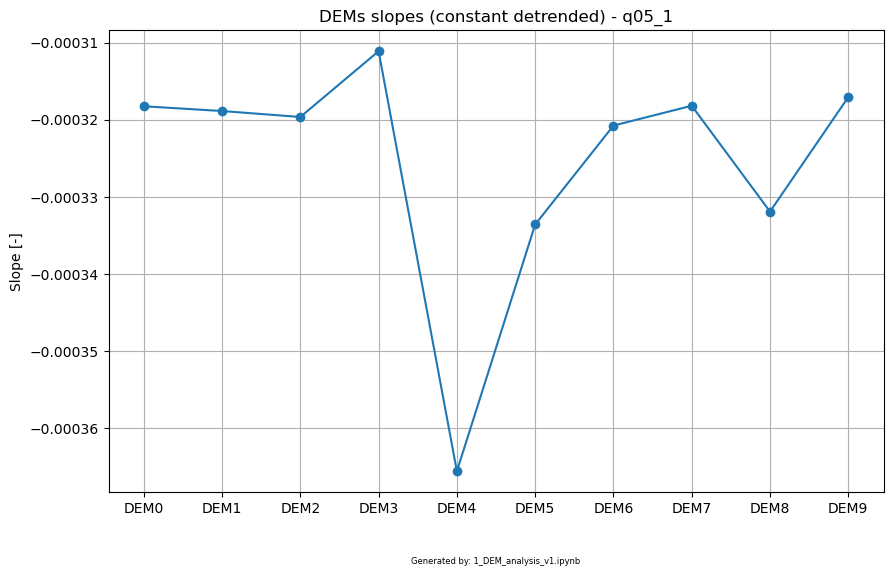

TypeError: expected string or bytes-like object, got 'NoneType'

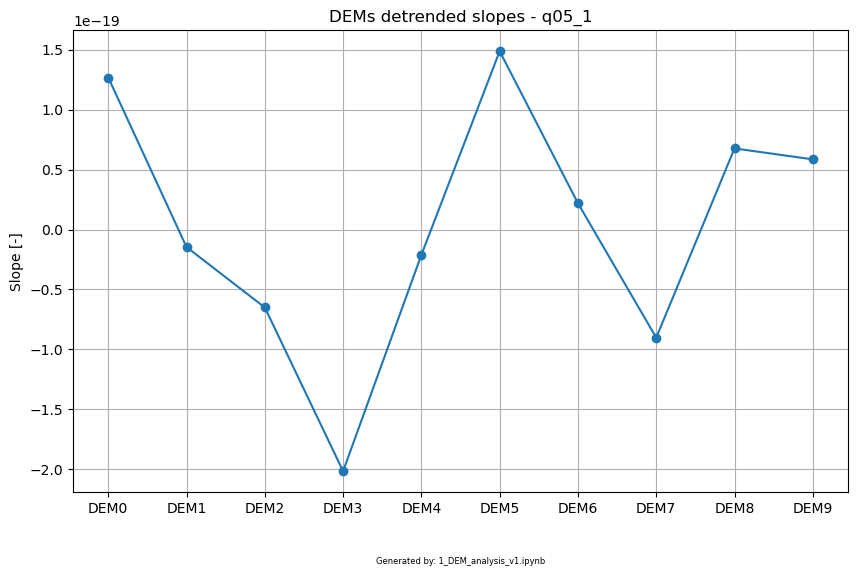

In [34]:
%matplotlib inline

# IMPORT LIBRARIES
import numpy as np
import os
import matplotlib.pyplot as plt
 
__file__ = '1_DEM_analysis_v1.ipynb'



# RUN NAMES -------------------------------------------------------------------
runs = ['q05_1', 'q07_1', 'q10_2', 'q15_2', 'q15_3', 'q20_2']
runs = ['q05_1']

home_dir = os.path.join(os.getcwd())
print(home_dir)
input_data_path = os.path.join(os.getcwd(), 'input_data')
output_data_path = os.path.join(home_dir, 'output_data')
if not os.path.exists(output_data_path):
        os.makedirs(output_data_path)
# PLOT MODE -------------------------------------------------------------------
# Only one option at time
plot_mode = [
    # 'overall_chart',
    'single_run_chart'
    ]



# INITIALIZE OVERALL PLOT -----------------------------------------------------
if 'overall_chart' in plot_mode:
    plt.subplots()
#%%============================================================================
# DEM VALUES ANALYSIS
# =============================================================================
"""
The aim of this section is the analysis of the DEM values
"""

    
for run in runs:
    
    output_dir = os.path.join(output_data_path, 'DEM_analysis')
    if not(os.path.exists(output_dir)):
        os.mkdir(output_dir)
    plot_dir = os.path.join(os.getcwd(), 'plots', 'DEM_analysis')
    if not(os.path.exists(output_dir)):
        os.mkdir(plot_dir)
    
    DEM_path = os.path.join(input_data_path, 'surveys',run)
    stack_path = os.path.join(output_data_path, 'DEM_stack', run + '_DEM_stack.npy')
    DEM_stack = np.load(stack_path)
    DEM_stack = np.where(DEM_stack==-999, np.nan, DEM_stack)
    dim_t, dim_y, dim_x = DEM_stack.shape
    
    # Number of bins and range
    num_bins = 100
    range_min = -50
    range_max = 25
    
    freq_dist_matrix = np.zeros((dim_t, num_bins))

    # =========================================================================
    # DEMs SLOPE AND RESIDUAL SLOPE
    # =========================================================================
    from scipy.interpolate import interp1d
    from scipy.stats import linregress
    
    
    DEMs_mean_profile = np.nanmean(DEM_stack, axis=1)
    
    # Assuming each row is a data series
    num_series = DEMs_mean_profile.shape[0]
    
    # Lists to store slopes and intercepts
    slopes = []
    intercepts = []
    
    # Interpolation and linear fitting
    for i in range(num_series):
        # x = np.arange(DEMs_mean_profile.shape[1])
        x = np.linspace(0, 50*(DEMs_mean_profile.shape[1]-1),DEMs_mean_profile.shape[1])
        y = DEMs_mean_profile[i, :]
        
        # Linear fitting
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Store the parameters
        slopes.append(slope)
        intercepts.append(intercept)
    
    # Convert lists to numpy arrays
    slopes = np.array(slopes)
    intercepts = np.array(intercepts)
    
    # PLOT THE SLOPE
    plt.figure(figsize=(10, 6))
    plt.plot(slopes, marker='o', linestyle='-')
    
    # Set x-ticks
    x_ticks = np.arange(num_series)
    x_tick_labels = [f'DEM{i}' for i in x_ticks]
    plt.xticks(ticks=x_ticks, labels=x_tick_labels)
    
    # plt.xlabel('Series Index')
    plt.ylabel('Slope [-]')
    plt.title('DEMs slopes (constant detrended) - ' + run)
    
    # Add text to the plot with the script name
    plt.text(0.5, -0.15, f"Generated by: {os.path.basename(__file__)}", transform=plt.gca().transAxes, ha='center', va='center', fontsize=6)
    
    plt.grid(True)
    
    # Save image and report
    # plot_path = os.path.join(plot_dir,run + '_DEM_constant_detrended_residual_slopes.pdf')
    plot_path = '/Users/erri/Downloads'
    # plt.savefig(plot_path, dpi=400, bbox_inches='tight')
    # plt.savefig(plot_path, dpi=400)
    plt.savefig(plot_path)
    plt.show()
    
    # COMPUTE DEMs SLOPES -----------------------------------------------------
    DEM_slopes = slopes + 0.01
    
    # TODO Save slopes array
    np.savetxt(os.path.join(output_dir,run + '_slope_analysis.txt'), DEM_slopes, header=', '.join(map(str, x_tick_labels)))
    
    
    # =========================================================================
    # DEMs DETRENDING
    # =========================================================================
    
    # COMPUTE THE DEMs DETRENDING ---------------------------------------------
    DEM_stack_detrended = np.copy(DEM_stack)
    
    x = np.linspace(0, 50*(DEMs_mean_profile.shape[1]-1),DEMs_mean_profile.shape[1])
    
    DEM_mean_list = []
    
    for i in range(num_series):
        for y in range(0,DEM_stack.shape[1]):
            
            # REMOVE THE RESIDUAL SLOPE -------------------------------------------
            DEM_stack_detrended[i,y,:] = DEM_stack[i,y,:]-slopes[i]*x
            
        # TRANSLATING THE DEM
        DEM_stack_detrended[i,:,:] = DEM_stack_detrended[i,:,:] - np.nanmean(DEM_stack_detrended[i,:,:])
        
        # COMPUTE THE DEMs MEAN
        DEM_mean_list.append(np.nanmean(DEM_stack_detrended[i,:,:]))
    
    # COMPUTE THE DEMs PROFILE AND LINEAR FITTING -----------------------------
    DEMs_detrended_mean_profile = np.nanmean(DEM_stack_detrended, axis=1)
    
    # Lists to store slopes and intercepts
    detrended_slopes = []
    detrended_intercepts = []
    
    # Interpolation and linear fitting
    for i in range(num_series):
        # x = np.arange(DEMs_mean_profile.shape[1])
        x = np.linspace(0, 50*(DEMs_detrended_mean_profile.shape[1]-1),DEMs_detrended_mean_profile.shape[1])
        y = DEMs_detrended_mean_profile[i, :]
        
        # Linear fitting
        detrended_slope, detrended_intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Store the parameters
        detrended_slopes.append(detrended_slope)
        detrended_intercepts.append(detrended_intercept)
    
    # Convert lists to numpy arrays
    detrended_slopes = np.array(detrended_slopes)
    detrended_intercepts = np.array(detrended_intercepts)
    
    # PLOT THE SLOPE
    plt.figure(figsize=(10, 6))
    plt.plot(detrended_slopes, marker='o', linestyle='-')
    
    # Set x-ticks
    x_ticks = np.arange(num_series)
    x_tick_labels = [f'DEM{i}' for i in x_ticks]
    plt.xticks(ticks=x_ticks, labels=x_tick_labels)
    
    # plt.xlabel('Series Index')
    plt.ylabel('Slope [-]')
    plt.title('DEMs detrended slopes - ' + run)
    plt.grid(True)
    
    # Add text to the plot with the script name
    plt.text(0.5, -0.15, f"Generated by: {os.path.basename(__file__)}", transform=plt.gca().transAxes, ha='center', va='center', fontsize=6)
    
    # Save image and report
    plot_path = os.path.join(plot_dir,run + '_DEM_full_detrended_residual_slopes.pdf')
    plt.savefig(plot_path, dpi=400, bbox_inches='tight')
    
    plt.show()
    
    # Create a new figure
    plt.figure(figsize=(10, 6))
    
    # Number of bins and range
    num_bins = 100
    range_min = -50
    range_max = 25
    
    for i in range(0,DEM_stack_detrended.shape[0]):
        
        # # Calculate histogram
        # hist, bin_edges = np.histogram(DEM_stack[i,:,:], bins=num_bins, range=(range_min, range_max))
        
        # # Calculate the bin centers
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # # Plot the histogram as a line plot
        # plt.figure(figsize=(10, 6))
        # plt.plot(bin_centers, hist, drawstyle='steps-mid')
        # plt.title('DEM ' + str(i))
        # plt.xlabel('Value')
        # plt.ylabel('Frequency')
        # plt.grid(True)
        # plt.show()
        
        
        # Calculate histogram
        hist, bin_edges = np.histogram(DEM_stack_detrended[i,:,:], bins=num_bins, range=(range_min, range_max), density=True)
        
        # Normalize hist values
        hist = hist/np.sum(hist)
        
        # Fill freq_dist_matrix matrix
        freq_dist_matrix[i,:] = hist
        
        # Calculate the bin centers
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Plot the histogram as a line plot
        plt.plot(bin_centers, hist, drawstyle='steps-mid', label=f'DEM {i}')
        
    # Add title and labels
    plt.title(run)
    plt.xlabel('DEM values [mm]')
    plt.ylabel('Value')
    
    # Add a vertical black line at x=0
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add a legend with row numbers
    plt.legend(title="Data Series")
    
    plt.grid(True)
    plt.show()
    
    np.save(os.path.join(output_dir, run + '_freq_dist_matrix.npy'), freq_dist_matrix)
    
    # SAVE DEMs STACK DETRENDED -----------------------------------------------
    np.save(os.path.join(DEM_path, run + '_DEM_detrended_stack.npy'), DEM_stack_detrended)
    
    # ========================================================================
    # DEMs VALUES DISTRIBUTION OF FREQUENCY
    # =========================================================================
    
    mean_array = np.nanmean(freq_dist_matrix, axis=0)
    std_array = np.nanstd(freq_dist_matrix, axis=0)

    # x_values = edges_entire_dataset[1:]+(edges_entire_dataset[1:]-edges_entire_dataset[:-1])/2
    plt.plot(bin_centers, mean_array, label=run, linewidth=1)
    
    # Fill the area around the mean with color representing the standard deviation
    plt.fill_between(bin_centers, mean_array - std_array, mean_array + std_array, alpha=0.2)
    
    
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Plot the histogram with fixed upper and lower limits
    lower_limit_x, upper_limit_x = -40, 20  # Replace with desired x-axis limits
    lower_limit_y, upper_limit_y = 0, 1.1*np.max(mean_array)  # Replace with desired y-axis limits
    plt.xlim(lower_limit_x, upper_limit_x)
    plt.ylim(lower_limit_y, upper_limit_y)
    
    # Add text to the plot with the script name
    plt.text(0.5, -0.2, f"Generated by: {os.path.basename(__file__)}", transform=plt.gca().transAxes, ha='center', va='center', fontsize=6)
    
    # Add labels and legend
    plt.xlabel('Elevation [mm]')
    plt.ylabel('Frequency')
    plt.title('DEM values distribution - ' + run)
    plt.legend()
    
    # Save image and report
    plot_path = os.path.join(plot_dir,run + '_mean_DEM_values_distribution.pdf')
    plt.savefig(plot_path, dpi=400, bbox_inches='tight')
    
    # Show the plot
    plt.show()
    

#%%============================================================================
# PLOT ALL THE DISTRIBUTION IN ONE CHART
# =============================================================================

runs = ['q05_1', 'q07_1', 'q10_2', 'q15_3', 'q20_2']

# Create a new figure
plt.figure(figsize=(10, 6))

for run in runs:
    output_dir = os.path.join(os.getcwd(), 'output_data', run, 'DEM_analysis')
    freq_dist_matrix = np.load(os.path.join(output_dir, run + '_freq_dist_matrix.npy'))
    mean_array = np.nanmean(freq_dist_matrix, axis=0)
    std_array = np.nanstd(freq_dist_matrix, axis=0)
    
    plt.plot(bin_centers, mean_array, label=run, linewidth=1)
    
    # Fill the area around the mean with color representing the standard deviation
    plt.fill_between(bin_centers, mean_array - std_array, mean_array + std_array, alpha=0.2)


plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Plot the histogram with fixed upper and lower limits
lower_limit_x, upper_limit_x = -40, 20  # Replace with desired x-axis limits
lower_limit_y, upper_limit_y = 0, 0.1  # Replace with desired y-axis limits
plt.xlim(lower_limit_x, upper_limit_x)
plt.ylim(lower_limit_y, upper_limit_y)

# Add text to the plot with the script name
plt.text(0.5, -0.15, f"Generated by: {os.path.basename(__file__)}", transform=plt.gca().transAxes, ha='center', va='center', fontsize=6)

# Add labels and legend
plt.xlabel('Elevation [mm]')
plt.ylabel('Frequency')
plt.title('DEM values distribution')
plt.legend()

# Save image and report
plot_path = os.path.join(os.getcwd(), 'output_data', 'REPORT_overall_DEM_values_distribution.pdf')
plt.savefig(plot_path, dpi=400, bbox_inches='tight')

# Show the plot
plt.show()
    
    

In [6]:
# IMPORT LIBRARIES
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from matplotlib import colors
from matplotlib.patches import FancyArrow

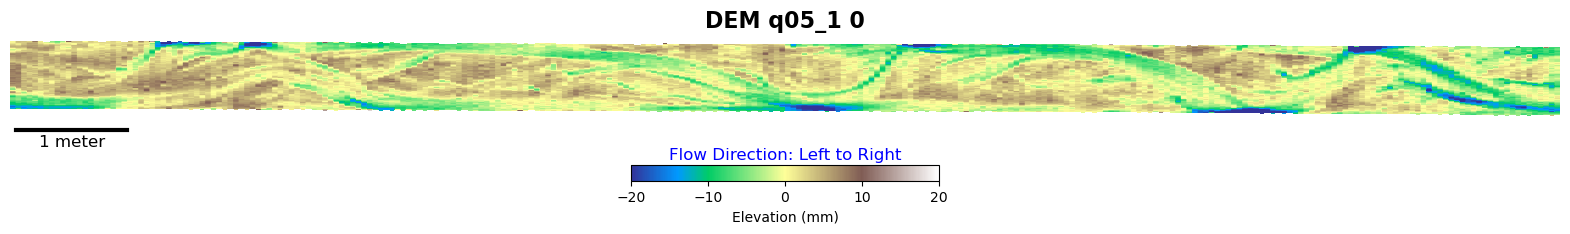

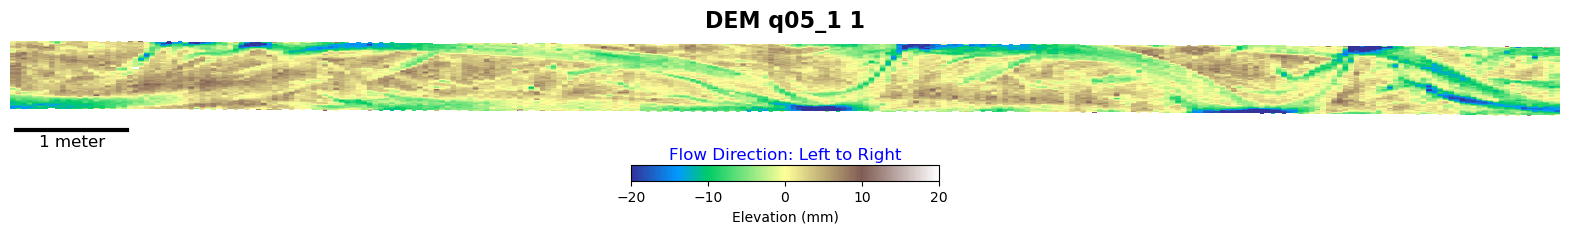

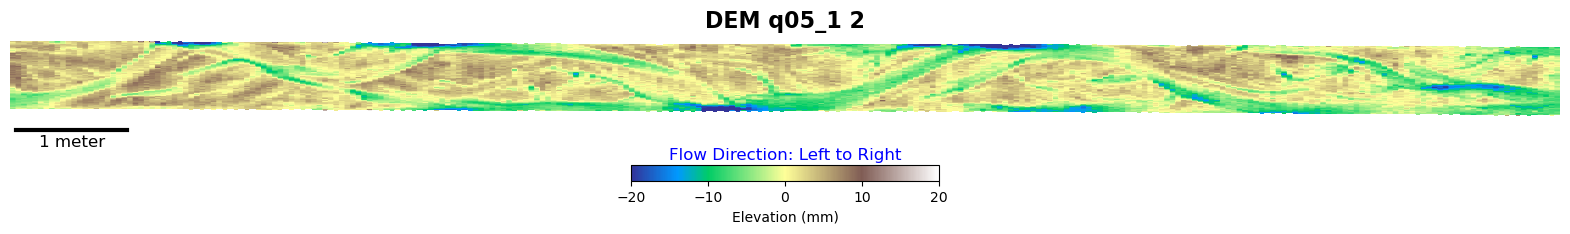

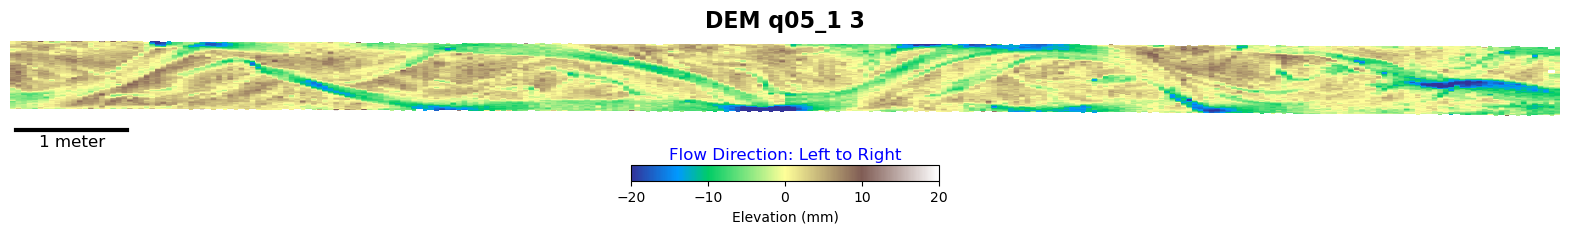

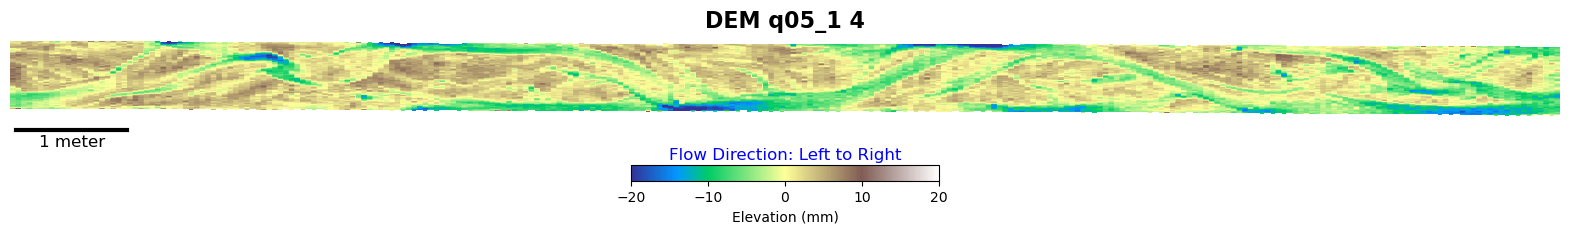

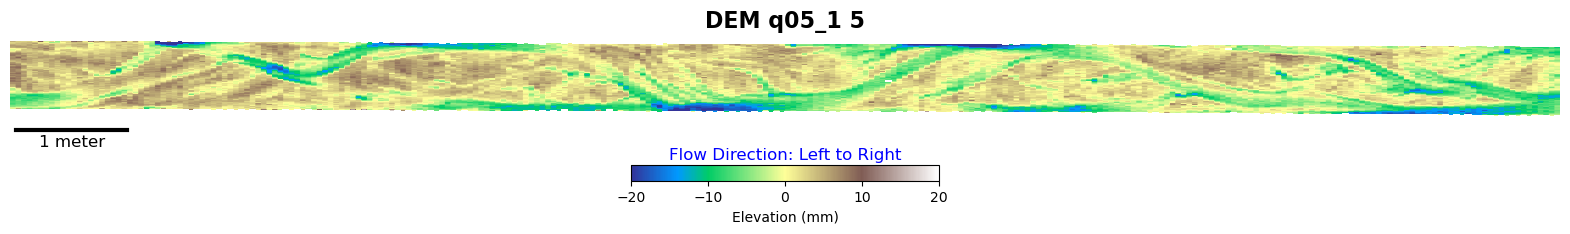

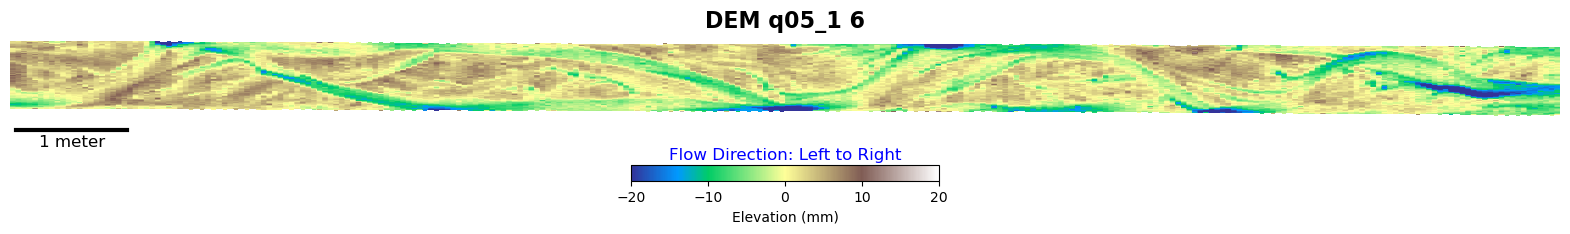

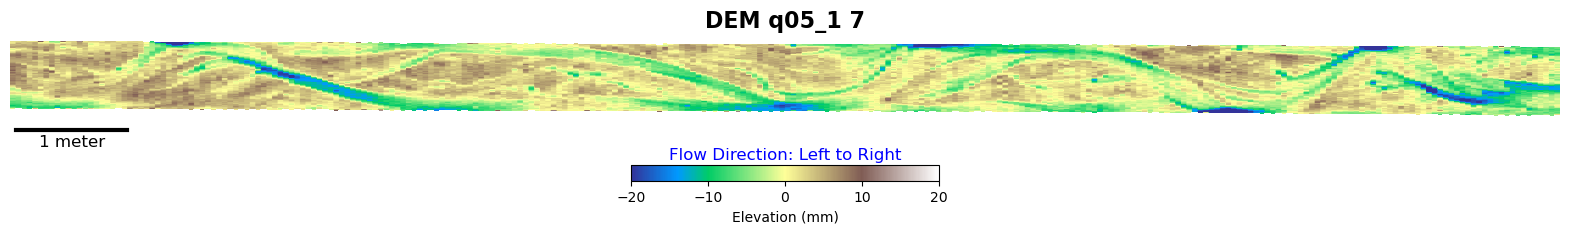

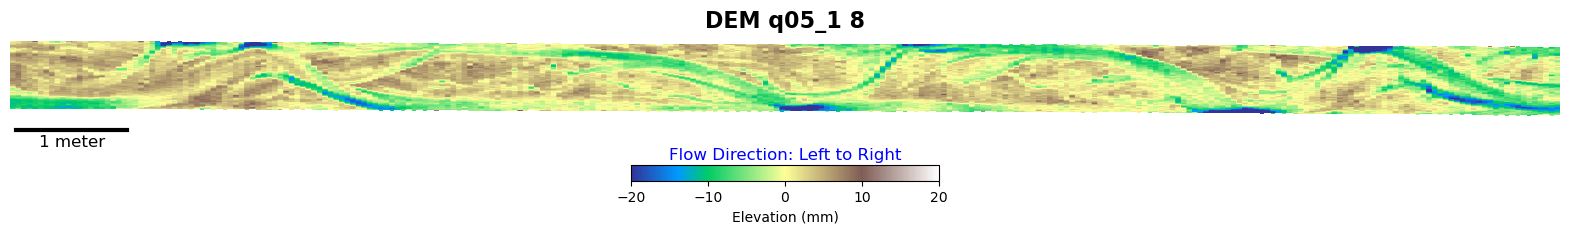

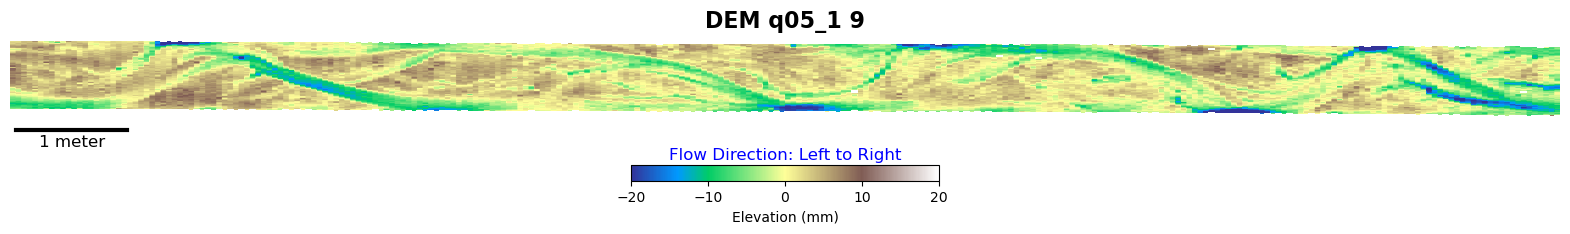

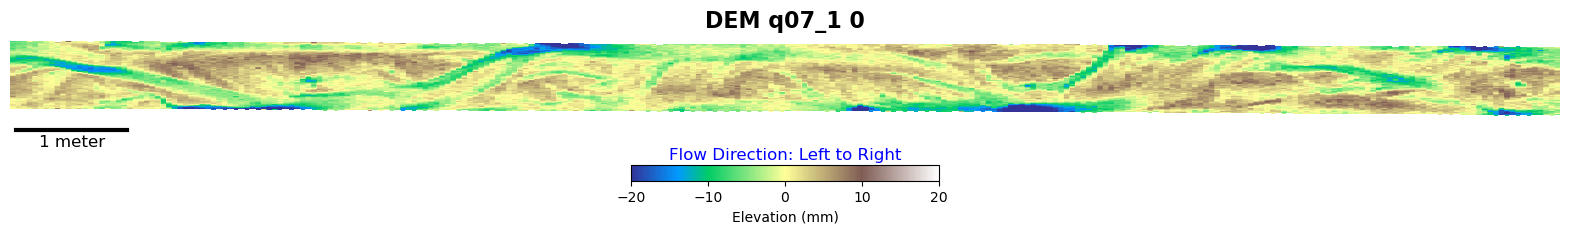

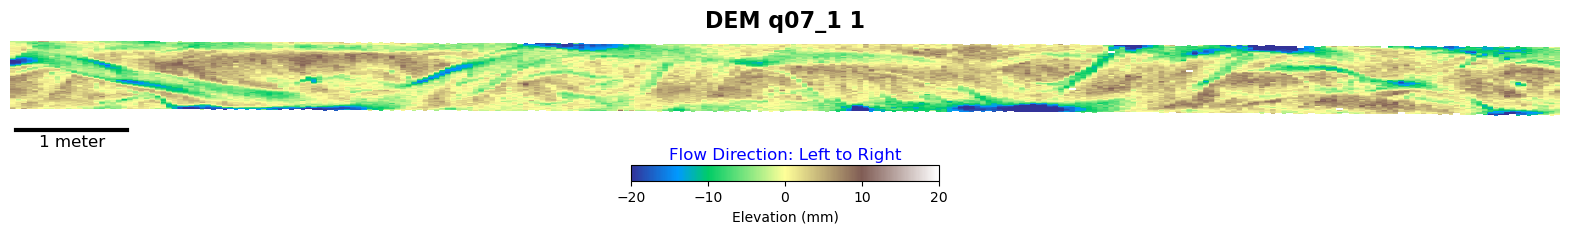

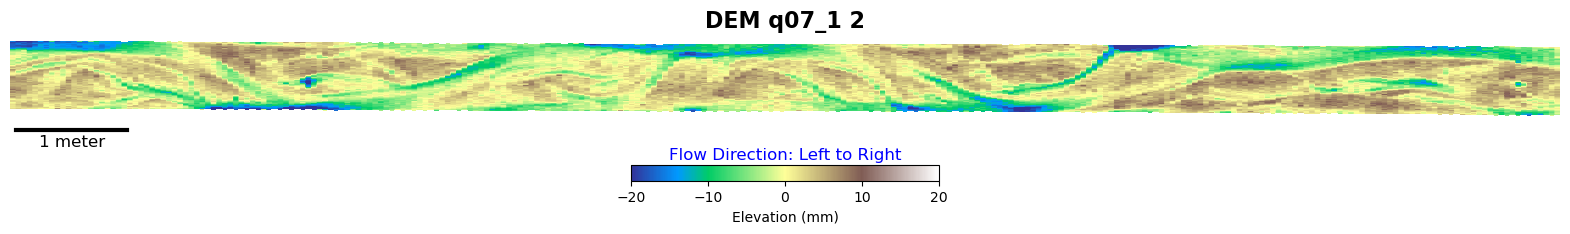

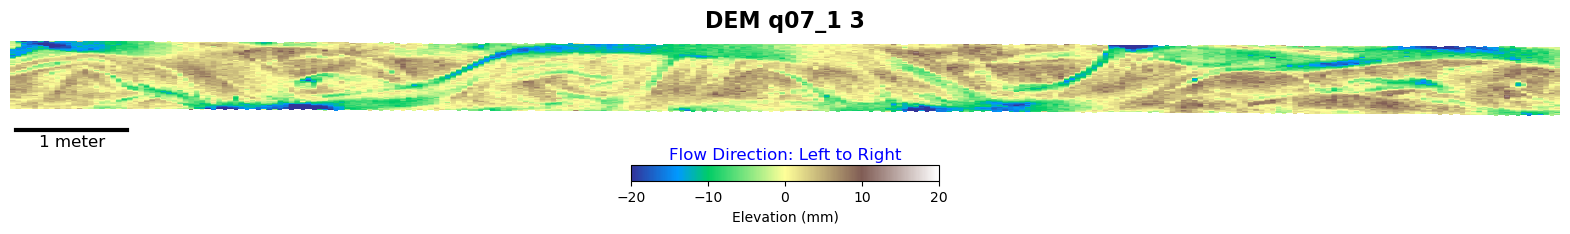

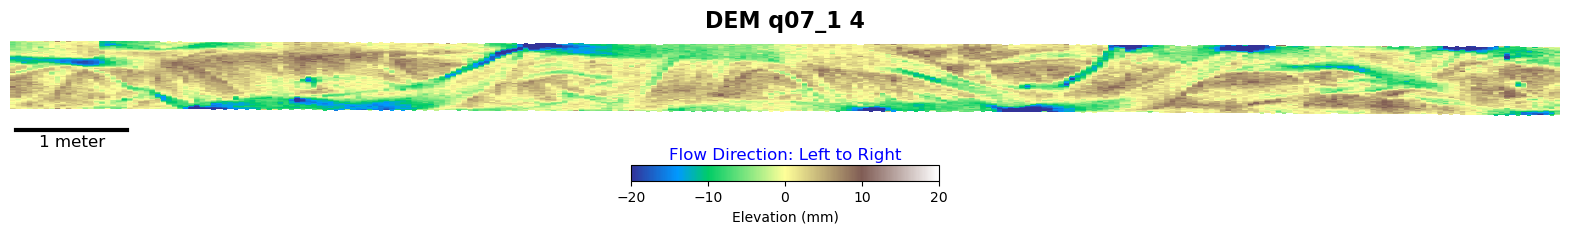

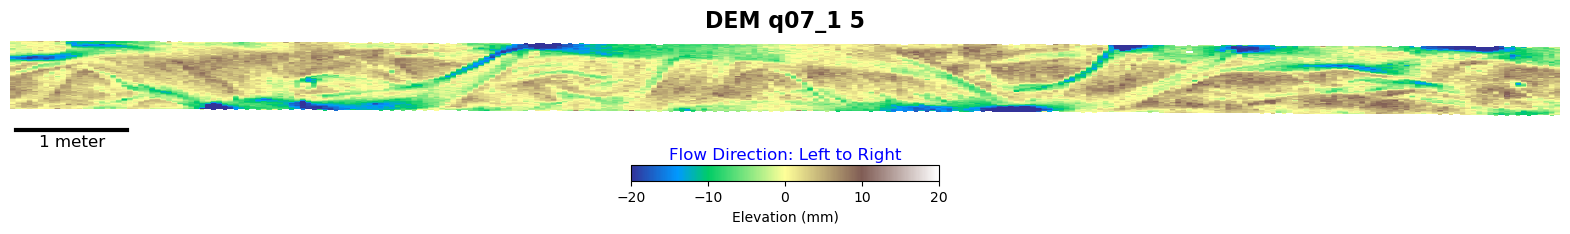

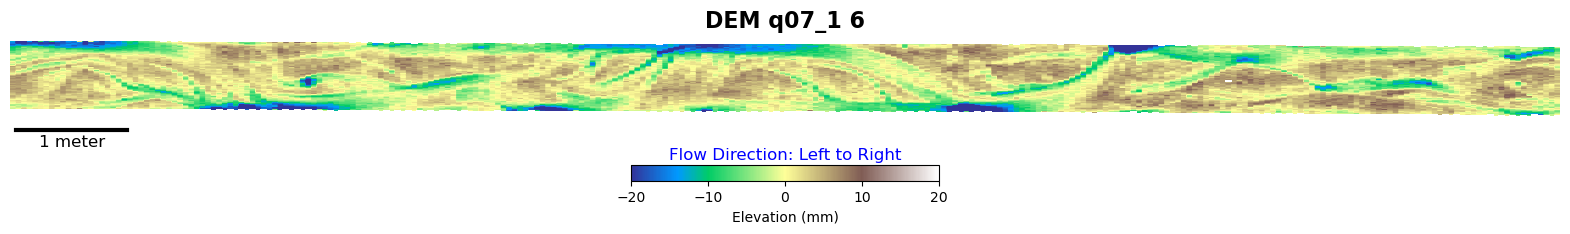

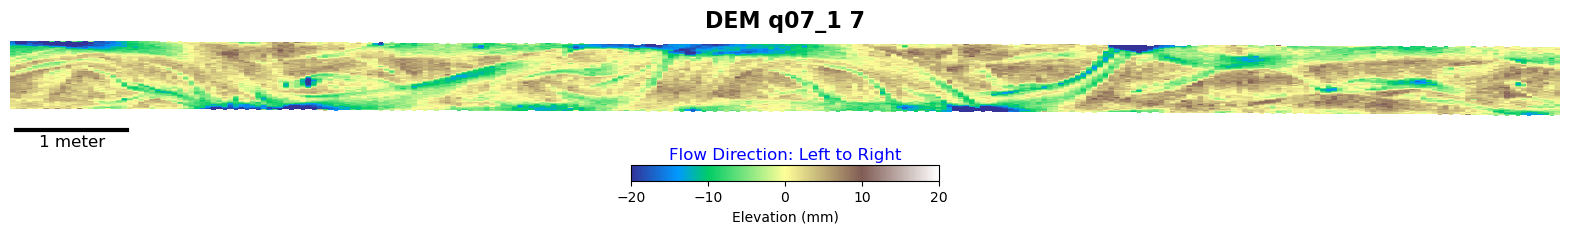

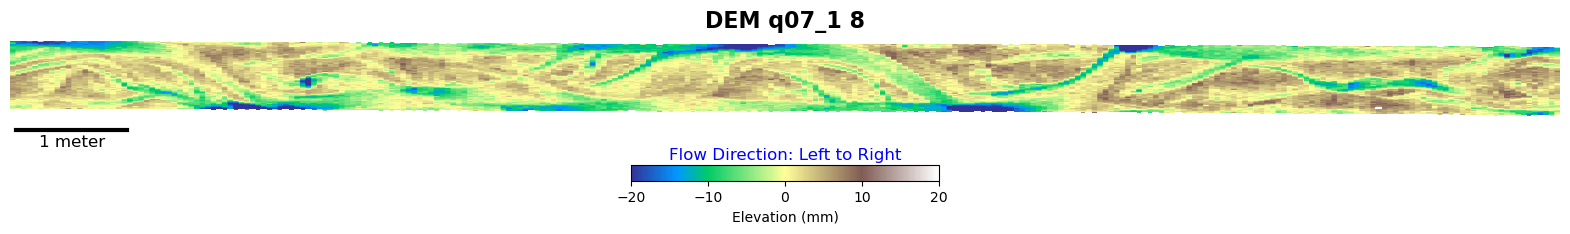

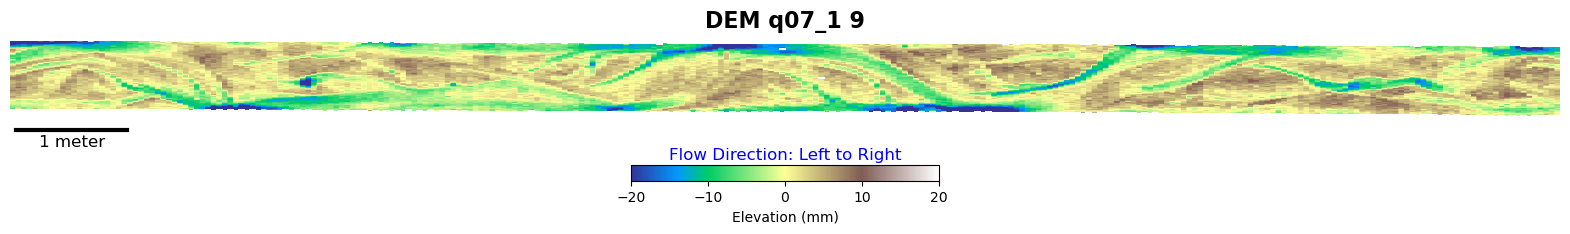

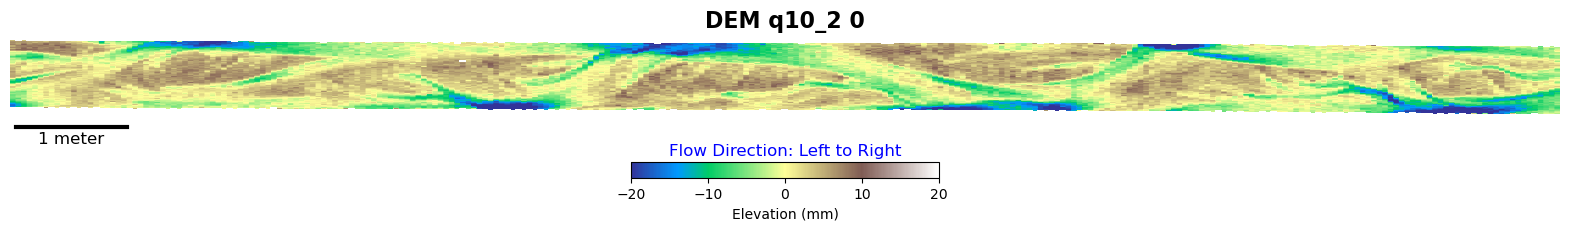

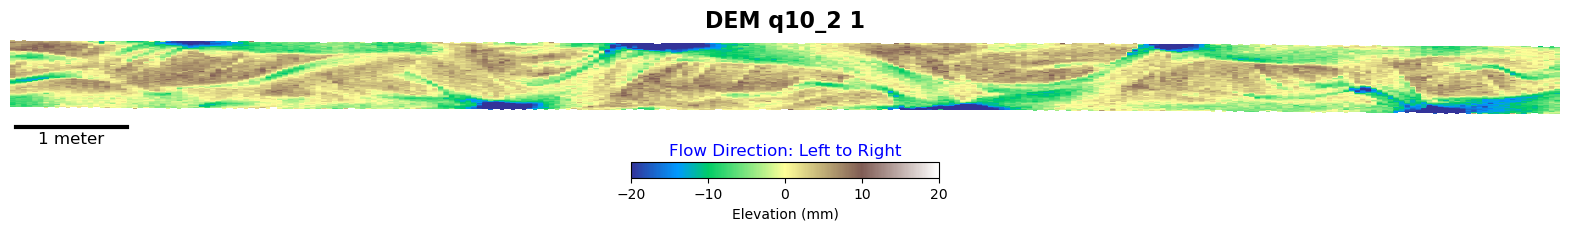

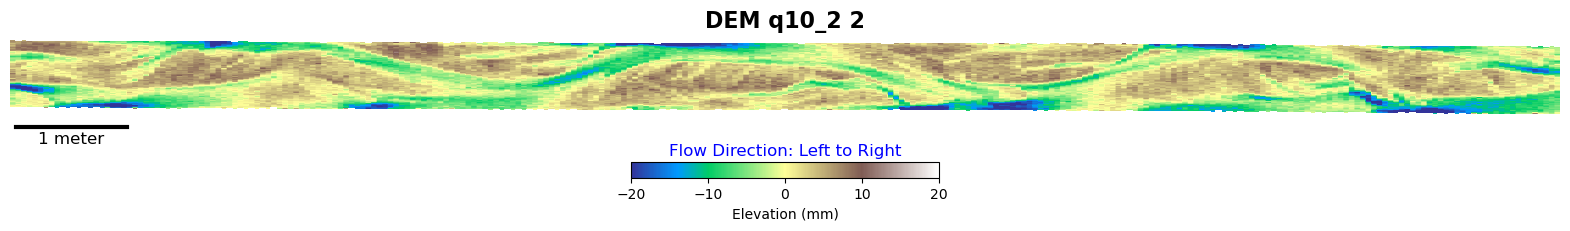

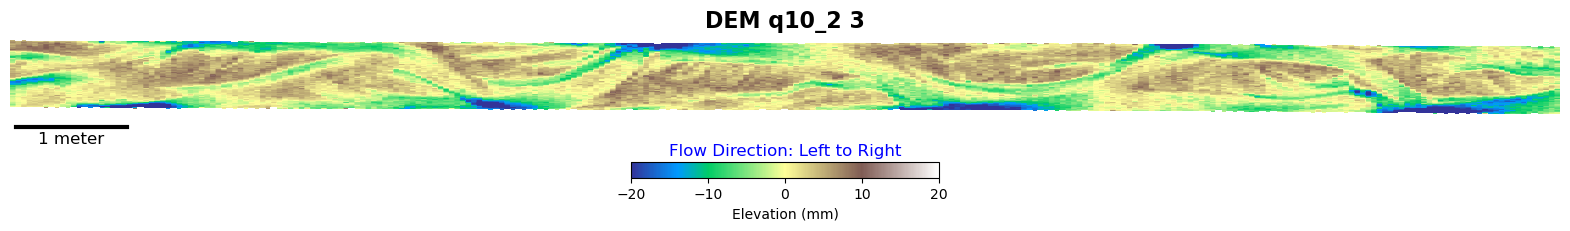

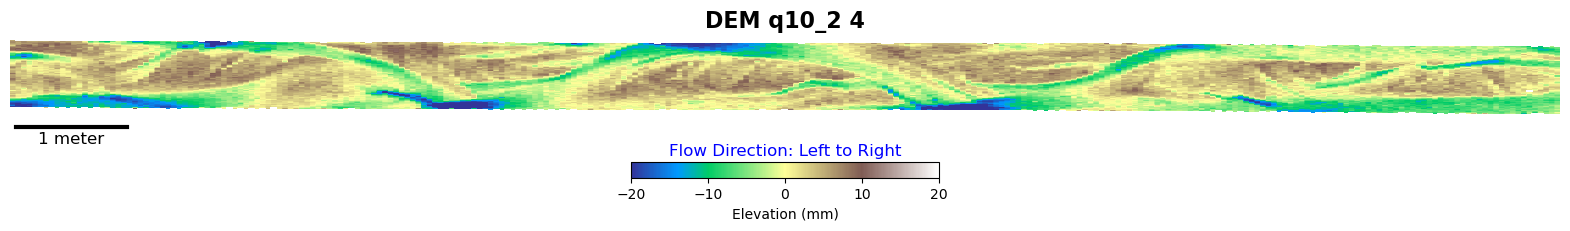

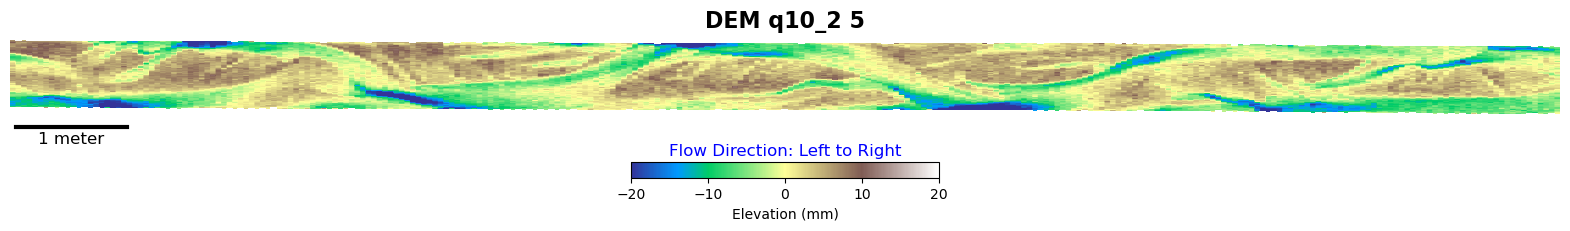

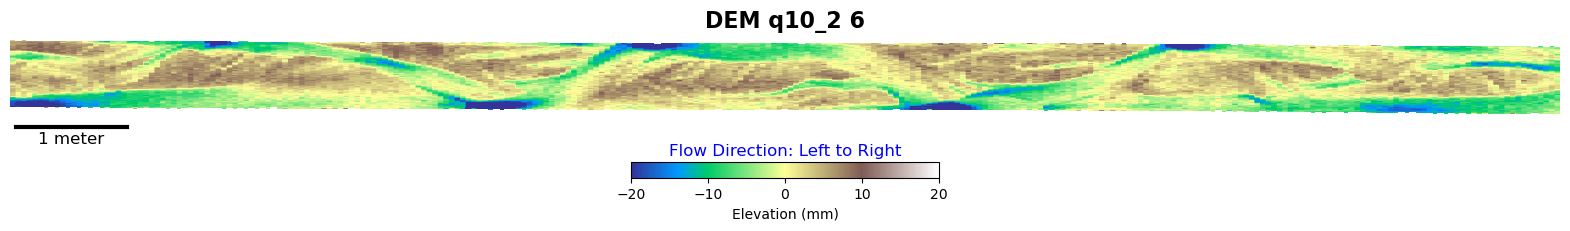

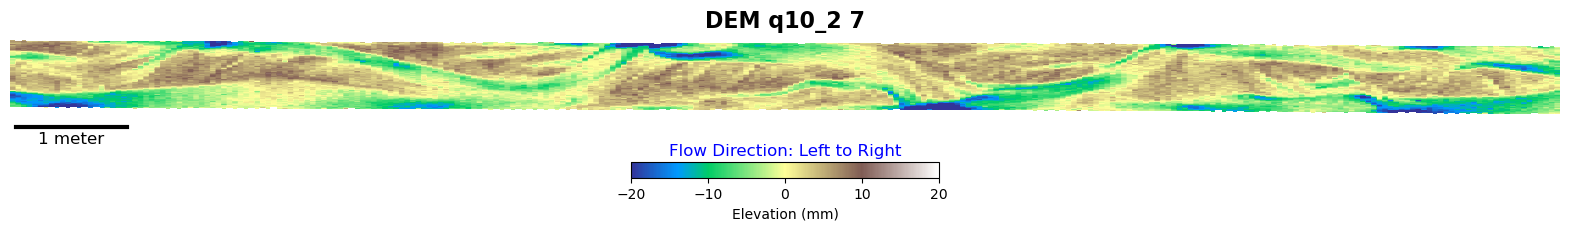

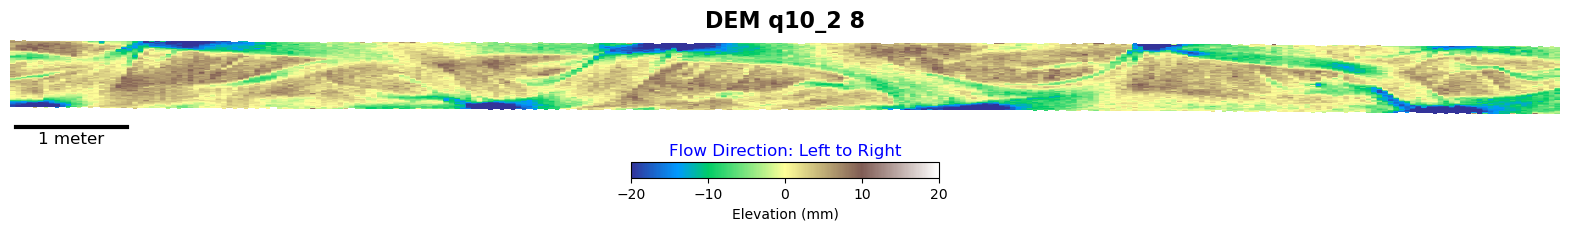

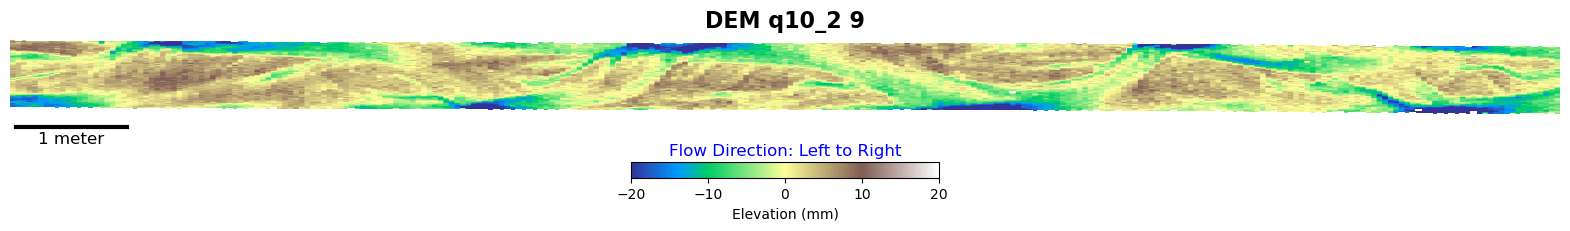

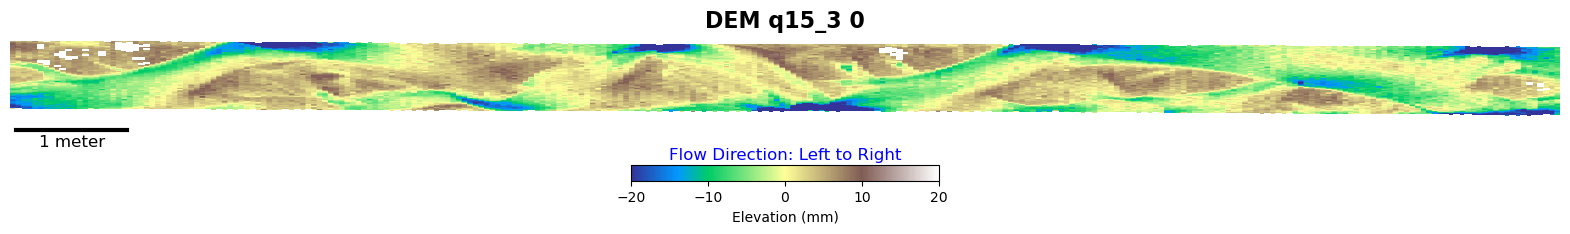

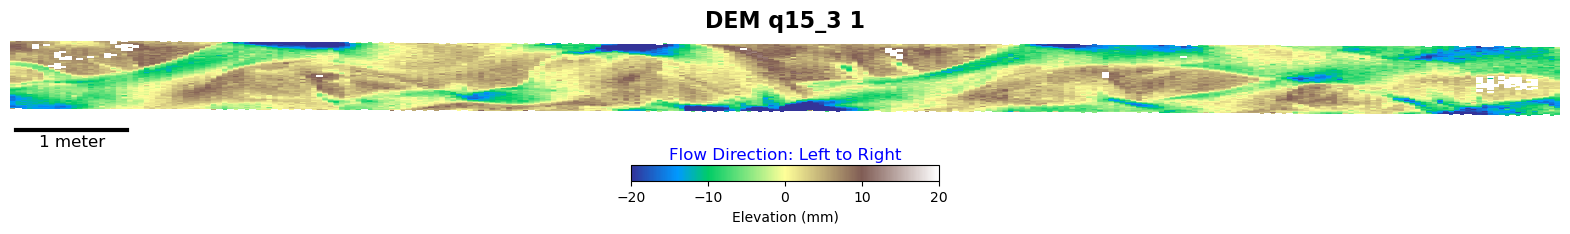

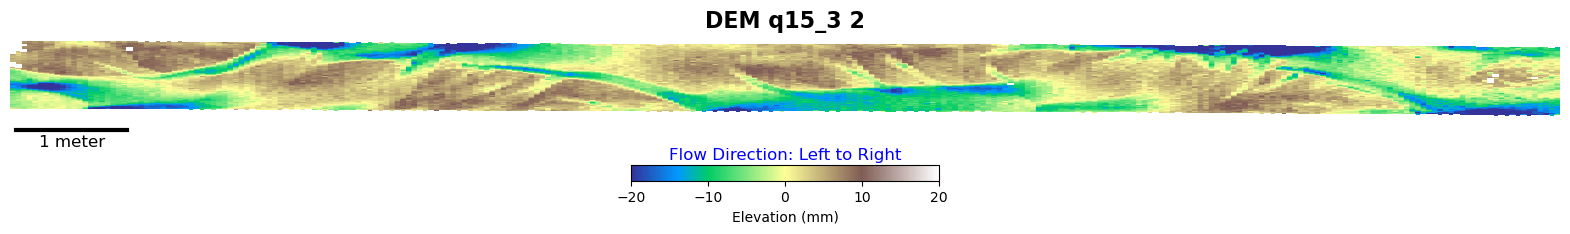

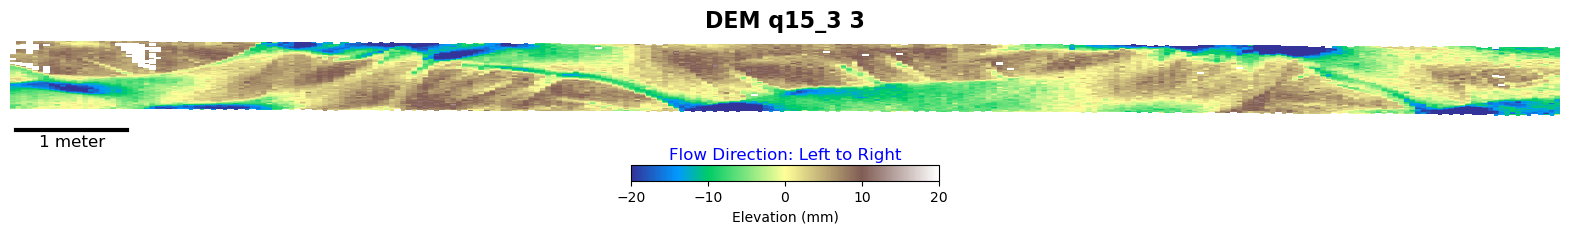

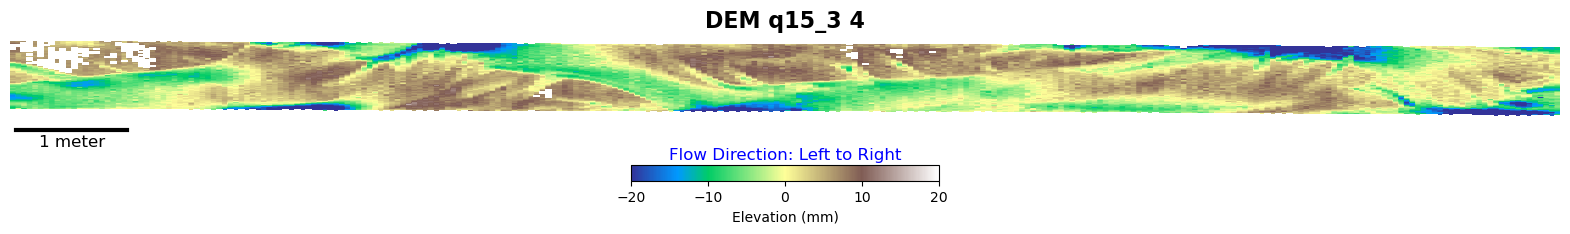

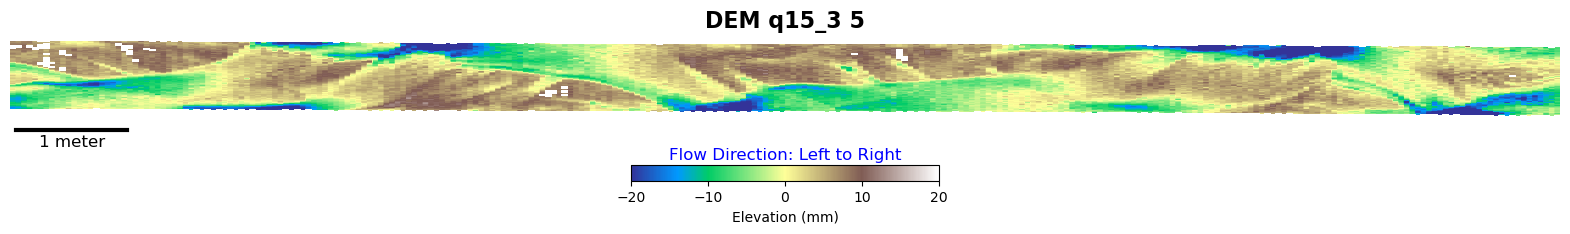

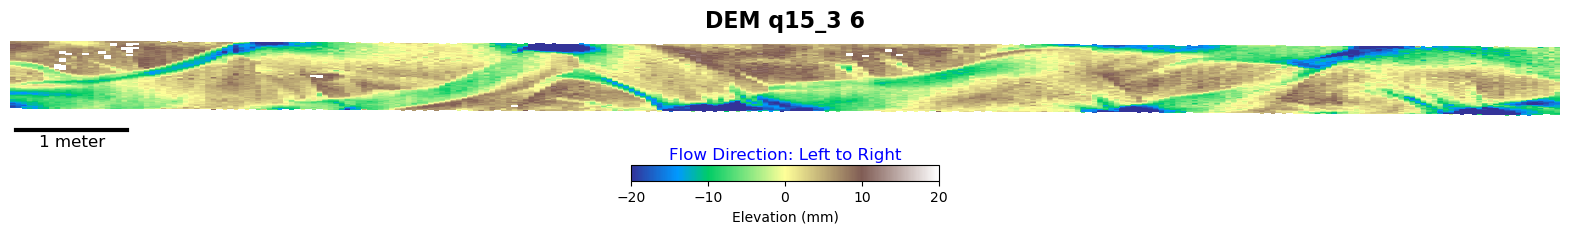

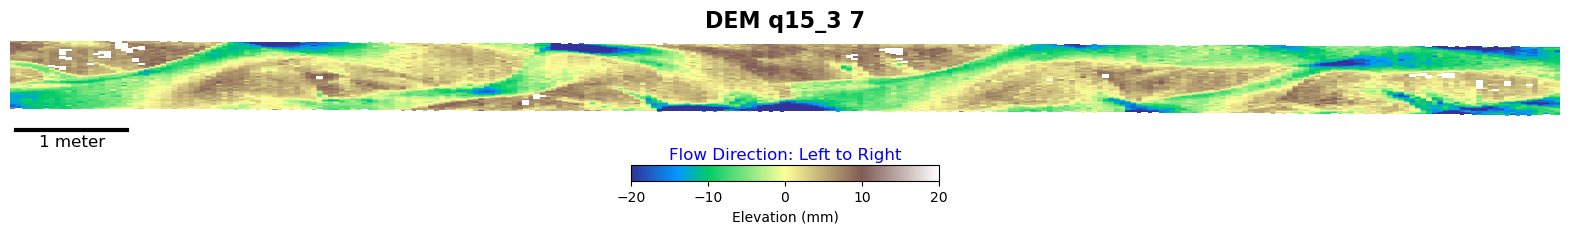

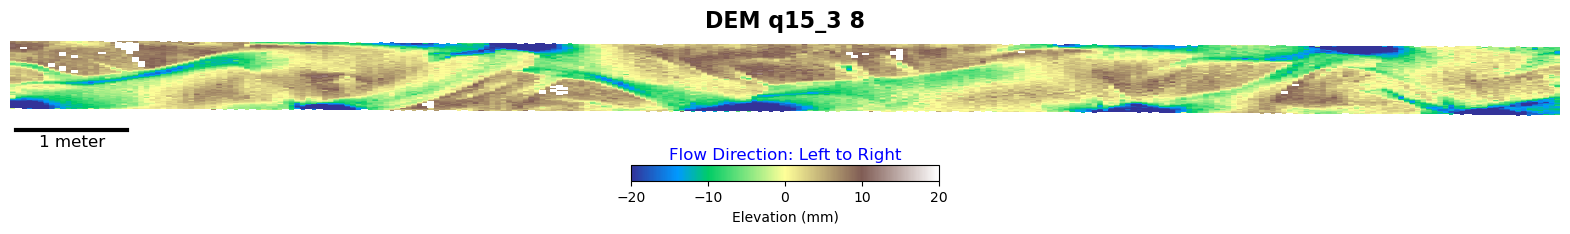

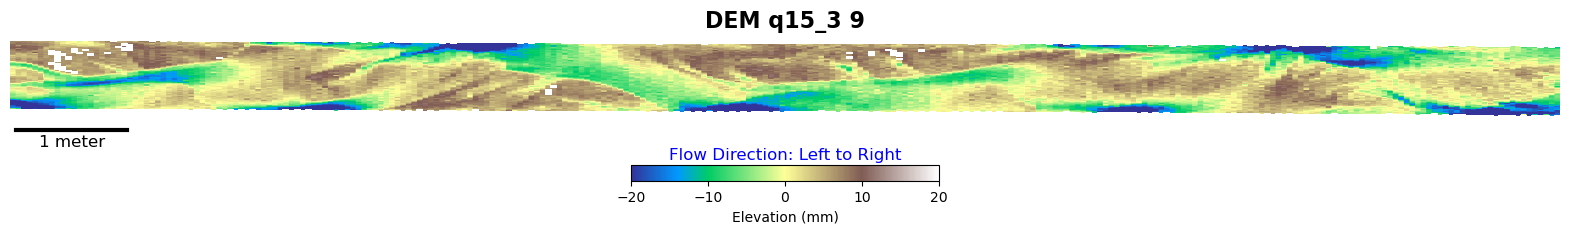

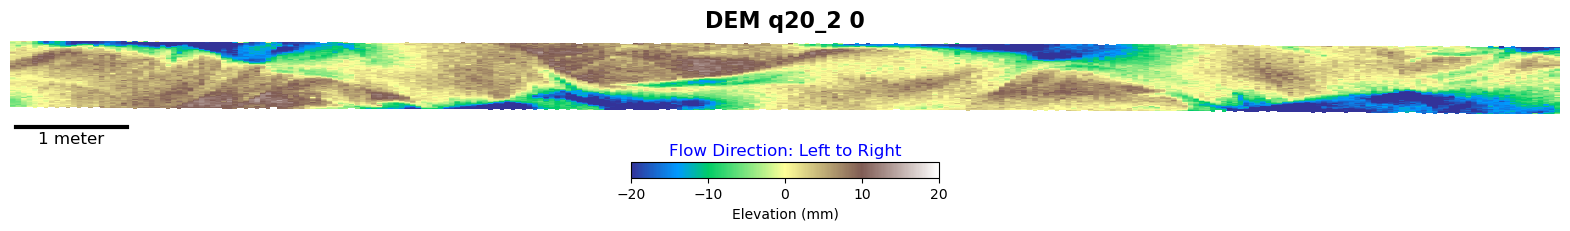

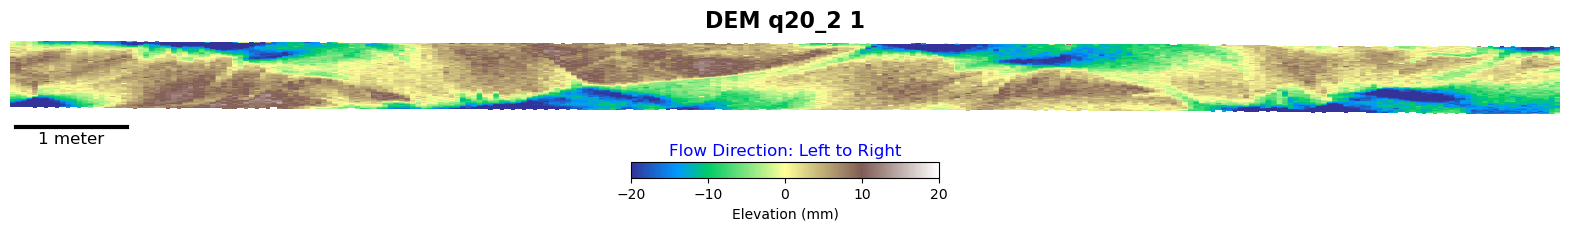

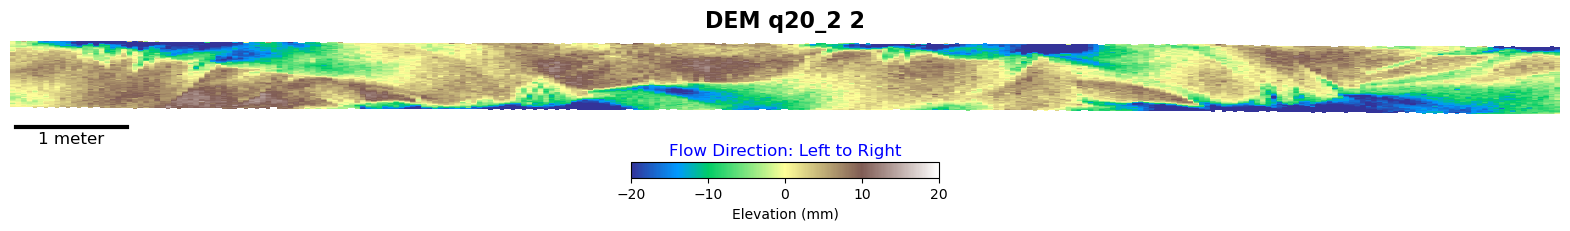

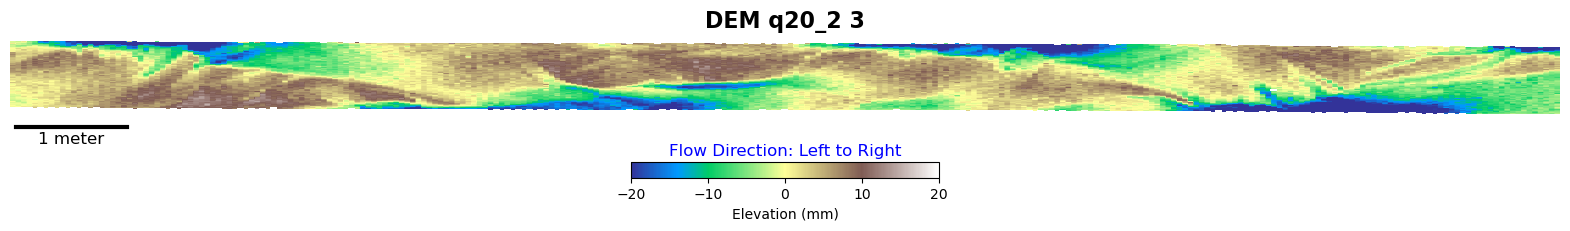

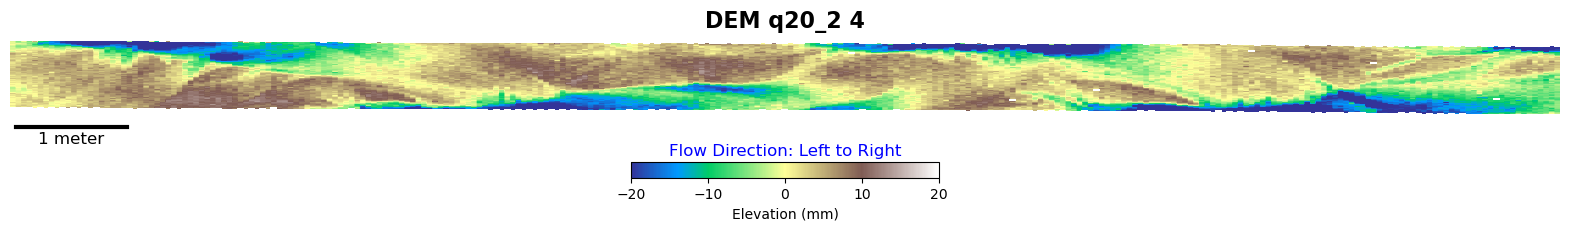

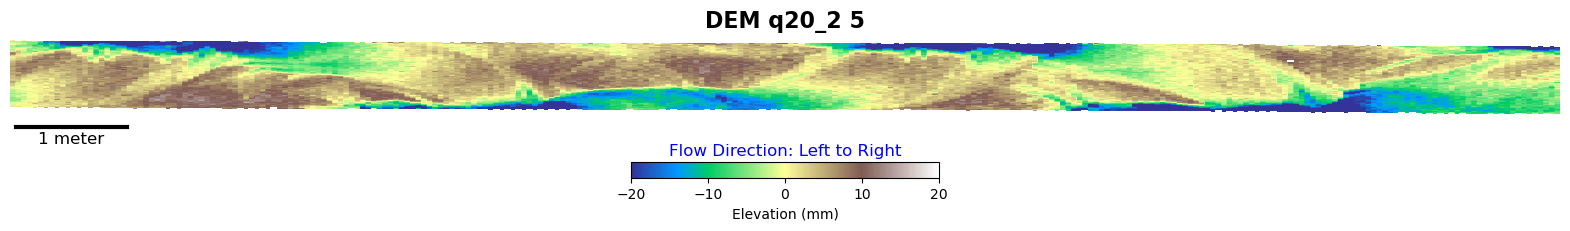

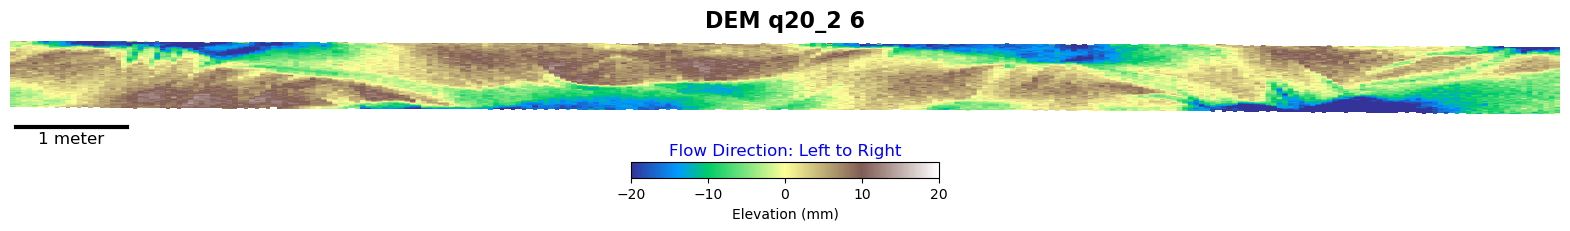

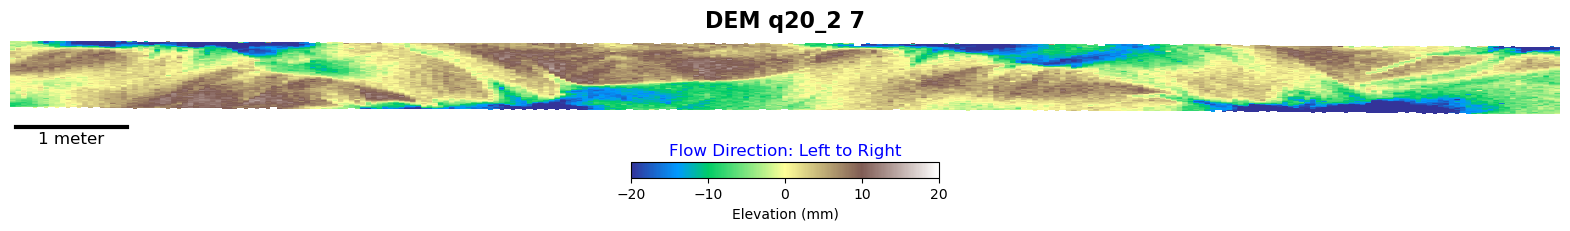

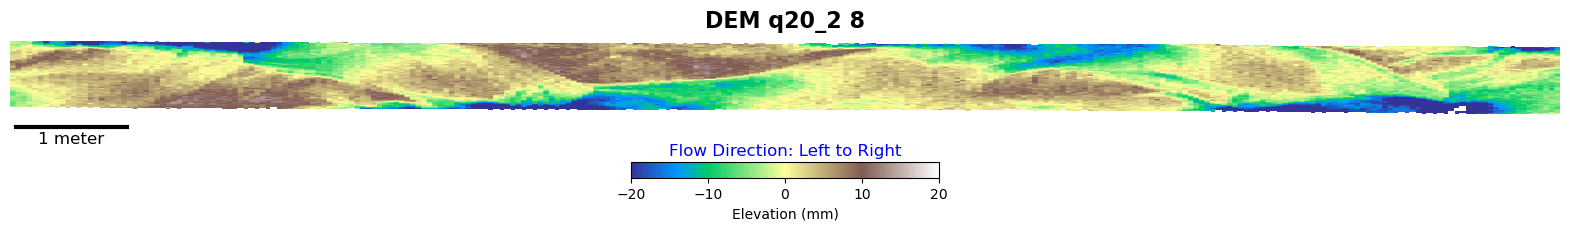

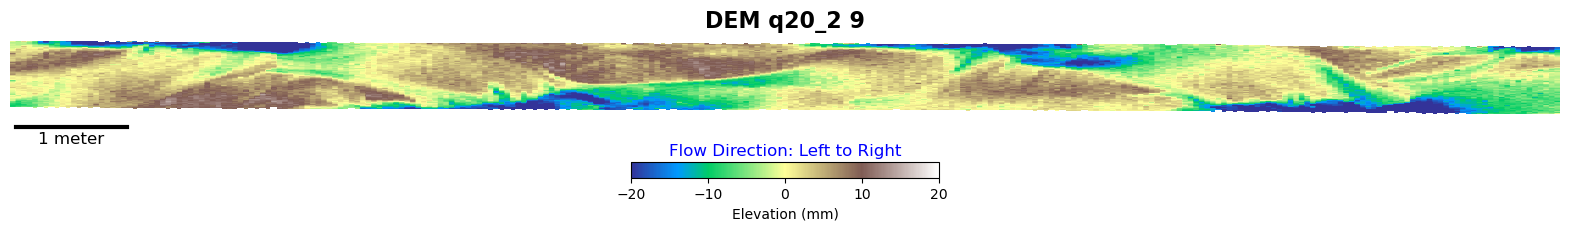

In [45]:
runs = ['q05_1', 'q07_1', 'q10_2', 'q15_3', 'q20_2']
# runs = ['q05_1']

for run in runs:
    # DEFINE INPUT AND OUTPUT PATHS 
    DEM_stack_path = os.path.join(os.getcwd(), 'output_data', 'DEM_stack', run + '_DEM_stack.npy')
    plot_dir = os.path.join(os.getcwd(), 'plots', 'DEM_analysis')
    if not(os.path.exists(plot_dir)):
        os.mkdir(plot_dir)
    
    # LOAD DEM STACK
    DEM_stack = np.load(DEM_stack_path)
    DEM_stack = np.where(DEM_stack == -999, np.nan, DEM_stack)
    dim_t, dim_y, dim_x = DEM_stack.shape

    transform = from_origin(0, 100, 1, 1)  # Dummy transform, adjust for actual geospatial data

    for i, dem in enumerate(DEM_stack):
        dem = np.repeat(dem, repeats=10, axis=1)  # Scale the DEM with the right ratio
        dem_filename = run + f"_DEM_{i}"  # Create a filename for the current DEM

        # Plotting the DEM
        fig, ax = plt.subplots(figsize=(20, 4))
        # Set color ramp using terrain colormap
        cmap = plt.get_cmap('terrain')  # You can change this to other colormaps like 'viridis', 'plasma', etc.
        norm = colors.Normalize(vmin=-20, vmax=+20)
        cax = ax.imshow(dem, cmap=cmap, norm=norm)  # Display the DEM as an image with the color ramp
        
        # Add color bar horizontally below the chart
        cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', pad=0.1, fraction=0.05)
        cbar.set_label('Elevation (mm)')

        ax.set_title(f"DEM {run} {i}", fontsize=16, weight='bold') # Add a centered title
        ax.set_xticks([]) # Remove x and y axis ticks
        ax.set_yticks([]) # Remove x and y axis ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        # Add a horizontal line segment as a reference scale (e.g., 50 units long)
        ax.plot([10, 210], [dim_y +20, dim_y+20], color="black", lw=3)
        ax.text(110, dim_y + 55, '1 meter', ha='center', va='bottom', fontsize=12)

        # Add flow direction text
        ax.text(0.5, -0.25, 'Flow Direction: Left to Right', 
                transform=ax.transAxes, ha='center', fontsize=12, color='blue')

        # Save the plot as a PNG file
        plt.savefig(os.path.join(plot_dir, f"{dem_filename}.pdf"), bbox_inches='tight', dpi=300)
        plt.show()
        plt.close(fig)
        
        # Saving the DEM as a TIFF file
        with rasterio.open(
            os.path.join(plot_dir, f'{dem_filename}.tif'), 'w',
            driver='GTiff',
            height=dem.shape[0],
            width=dem.shape[1],
            count=1,
            dtype=dem.dtype,
            crs='EPSG:4326',  # Adjust this CRS to match your data
            transform=transform,
        ) as dst:
            dst.write(dem, 1)